Machine Learning Classification Example Using Exasol and R
================

-   [Train locally, predict in Exasol](#train-locally-predict-in-exasol)
    -   [Send model to BucketFS](#send-model-to-bucketfs)
    -   [Send data to Exasol](#send-data-to-exasol)
    -   [Make prediction using UDF](#make-prediction-using-udf)
-   [Train and predict in Exasol](#train-and-predict-in-exasol)
-   [Bonus: Predict via UDF in SQL](#bonus-predict-via-udf-in-sql)

The following demo illustrates how to use R and Exasol, both as standalone tools and combined, to run a machine learning algorithm such as Random Forests (RF) on some data. A central feature is the use of Exasol R package and especially Exasol's user defined functions (UDFs).

> UDF scripts provide you with the ability to program your own analyses, processing or generation functions and execute them in parallel inside Exasol's high performance cluster. See [Exasol User Manual](https://www.exasol.com/support/secure/attachment/70209/EXASOL_User_Manual-6.1.0-en.pdf) for more information.

UDF scripts play a pivotal role and provide the user with a flexible interface for implementing every requirement by integrating Java, Lua, Python and R language to Exasol native environment. However, Exasol ecosystem is not the only place we can make use of UDFs. Exasol R package also allows for the use of UDFs via `exa.createScript()` function which deploys R code dynamically from any R environment into Exasol database in parallel. See `?exa.createScript` for more information.

The typical (supervised) learning process starts with training a model on some sample training data. Then, the trained model can be used to make predictions on separate (unseen) test data. The data in our case consists of housing data from the [Boston Housing](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/) dataset. This will be a regression exercise since the response variable we are trying to predict is a continuous one, the median value of housing `medv`.

Requirements:

-   [R programming language](https://www.r-project.org/)
-   [RStudio](https://www.rstudio.com/)
-   [Exasol R package](https://github.com/EXASOL/r-exasol)
-   [Exasol Community Edition](https://www.exasol.com/portal/display/DOWNLOAD/Free+Trial)
-   SQL development tool
-   ODBC and [Exasol ODBC Driver](https://www.exasol.com/portal/display/DOWNLOAD/6.1)
-   [BucketFS Explorer](https://github.com/EXASOL/bucketfs-explorer)

Conventionally, one would load the data from a local machine into R, RStudio or a Jupyter Server. Then, you would run the analysis by training the model, evaluating and making predictions in such environment. However, we want to make use of Exasol database and this opens up the possibility of two additional scenarios:

-   Train locally and make predictions in Exasol
-   Train and make predictions in Exasol


Train locally, predict in Exasol
================================

First we need to install, load and setup the r-exasol packages.

In [1]:
# Install devtools if needed
install.packages("devtools",repos = "http://cran.us.r-project.org")

# Install package using devtools
devtools::install_github("EXASOL/r-exasol")
library(exasol)   # Exasol package

also installing the dependencies ‘brew’, ‘commonmark’, ‘praise’, ‘remotes’, ‘roxygen2’, ‘testthat’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done



✔  checking for file ‘/tmp/Rtmp8dZes3/remotes53e8f41a6a/exasol-r-exasol-ba0fbda/DESCRIPTION’
─  preparing ‘exasol’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  installing the package to process help pages
─  saving partial Rd database (1.6s)
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘exasol_5.3.0.tar.gz’
   


Loading required package: DBI
EXASOL SDK 5.3.0 loaded.


The setup of exasol defines necessary information for connecting to Exasol and the BucketFS.

In [9]:
EXASOL_HOST = "10.10.10.11:8888"
EXASOL_USER = "sys"
EXASOL_PASSWORD = "exasol"
EXASOL_BUCKETFS_HOST = "10.10.10.11:6583"
EXASOL_BUCKETFS_USER = "w"
EXASOL_BUCKETFS_PASSWORD = "write"
EXASOL_BUCKETFS_USE_HTTPS = FALSE
EXASOL_BUCKETFS_SERVICE = "bfsdefault"
EXASOL_BUCKETFS_BUCKET = "default"
MODEL_NAME= "rf_model"
EXASOL_BUCKETFS_URL_PREFIX = if (EXASOL_BUCKETFS_USE_HTTPS) {"https://" } else {"http://"}
EXASOL_BUCKETFS_PROTOCOL <- if(EXASOL_BUCKETFS_USE_HTTPS) "https" else "http"
EXASOL_BUCKETFS_PATH = sprintf("/%s/%s",EXASOL_BUCKETFS_SERVICE,EXASOL_BUCKETFS_BUCKET)
UDF_ENV=list(EXASOL_BUCKETFS_PROTOCOL=EXASOL_BUCKETFS_PROTOCOL,
             EXASOL_BUCKETFS_HOST=EXASOL_BUCKETFS_HOST,
             EXASOL_BUCKETFS_USER=EXASOL_BUCKETFS_USER,
             EXASOL_BUCKETFS_PASSWORD=EXASOL_BUCKETFS_PASSWORD,
             EXASOL_BUCKETFS_PATH=EXASOL_BUCKETFS_PATH,
             EXASOL_BUCKETFS_BUCKET=EXASOL_BUCKETFS_BUCKET,
             EXASOL_BUCKETFS_SERVICE=EXASOL_BUCKETFS_SERVICE,
             MODEL_NAME=MODEL_NAME)

After installing the r-exasol package, we need to load all necessary libraries.

In [19]:
install.packages("RODBC",repos = "http://cran.us.r-project.org")
install.packages("ggplot2",repos = "http://cran.us.r-project.org")
install.packages("randomForest",repos = "http://cran.us.r-project.org")
install.packages("RCurl",repos = "http://cran.us.r-project.org")
install.packages("tictoc",repos = "http://cran.us.r-project.org")

# load necassrary libraries for local training
library(RODBC)    # ODBC connectivity
library(ggplot2)  # Plotting
library(randomForest)    # Random forests for regression and classification
library(RCurl)           # HTTP communication
library(tictoc)

Warning message in install.packages("RODBC"):
“installation of package ‘RODBC’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Next, we start by loading the data in R. The Boston Housing dataset is available through the `mlbench` package. This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It was obtained from the StatLib archive (http://lib.stat.cmu.edu/datasets/boston), and has been used extensively throughout the literature to benchmark algorithms. 

In [20]:
install.packages("mlbench",repos = "http://cran.us.r-project.org")
library(mlbench)  # Library containing the Boston Housing dataset

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


After loading the data in our environment we will make a split for training and testing sets. This can be done in many ways but one way is to randomly generate indices that will subset rows from the main set. The ratio of the split is arbitrary and depends on data and application at hand. In this simple case will hold roughly 75% of the data for training and the other 25% for testing purposes.

In [21]:
# Load data
data("BostonHousing")

# Generate random indices (75% of the sample size)
set.seed(42)
indices <- sample(nrow(BostonHousing),size=floor(nrow(BostonHousing) * 0.75))

# Add a dummy variable with 2 levels "Train" and "Test"
BostonHousing$split = factor(NA, levels = c("Train", "Test"))

# Assign predefined rows respectively to "Train" and "Test" subsets
BostonHousing$split[indices]  = "Train"
BostonHousing$split[-indices] = "Test"

# Add id variable
BostonHousing$id = seq(1:nrow(BostonHousing))

Now we can train a basic random forest model on our data and see which variables contribute the most to predicting the median house value.

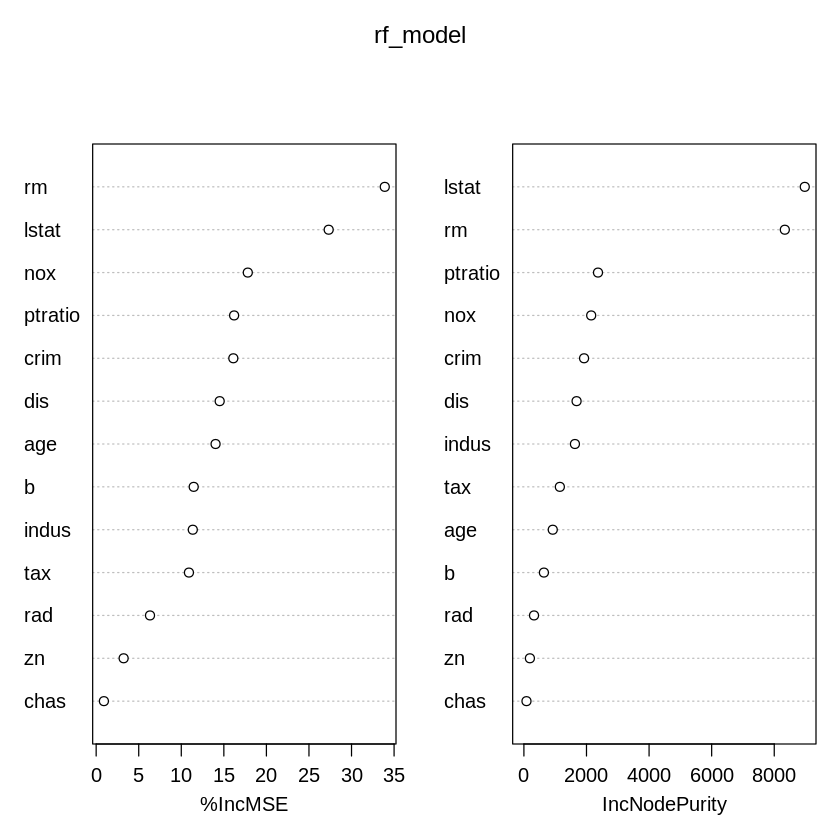

In [7]:
set.seed(42)
# Run model (note that we filter only for the training data (split=="Train"))
rf_model = randomForest(medv ~ .-split -id,
                        data = BostonHousing[BostonHousing$split=="Train",],
                        importance = TRUE)

# See which variables are important in predicting house prices
varImpPlot(rf_model)
# rm    - number of rooms per house
# lstat - % lower status of the population

Send model to BucketFS
----------------------

UDF scripts are executed in parallel on the Exasol cluster and in our case for the prediction such script needs to have access to the model we just trained. While it is possible to use any file service, when considering performance it is more efficient to have a storage space in the local cluster nodes. Keep in mind that the Exasol database cluster stores only tables and we cannot simply upload our model in there. The *Exasol BucketFS* file system has been created to handle such needs.

> The Exasol BucketFS file system has been developed for such use cases, where data should be stored synchronously and replicated across the cluster... this concept can be used to extend script languages and even to install completely new script languages on the Exasol cluster. [Exasol User Manual](https://www.exasol.com/support/secure/attachment/70209/EXASOL_User_Manual-6.1.0-en.pdf)

Files can be sent and retrieved from BucketFS in the following ways:

-   Using packages that allow HTTP communication in R (`httr` or `RCurl`)
-   [BucketFS Explorer](https://github.com/EXASOL/bucketfs-explorer) (drag and drop tool provided by Exasol which requires a connection to ExaOperation,)
-   Using `curl` commands (will not be shown here)

With the first method we will use the `RCurl` package. It is important to note that the model which lives in our R environment now has to be serialized (converted into raw text). When we want to retrieve it we can unserialize it and return it to its original filetype. See `?serialize` for more information.

In [10]:
# Define options for the authentication
curl_opts = curlOptions(userpwd  = sprintf("%s:%s",EXASOL_BUCKETFS_USER,EXASOL_BUCKETFS_PASSWORD),
                        verbose  = FALSE,
                        httpauth = AUTH_BASIC)

url = sprintf("%s://%s/%s/%s",EXASOL_BUCKETFS_PROTOCOL,EXASOL_BUCKETFS_HOST,EXASOL_BUCKETFS_BUCKET,MODEL_NAME)
print(sprintf("Upload model to %s",url))
# Transfer model to the bucket
httpPUT(
  # EXABucket URL
  url = url,
  # It is important to serialize the model
  content = serialize(rf_model, ascii = FALSE, connection = NULL),
  # EXABucket: authenticate
  curl = getCurlHandle(.opts = curl_opts)
)

[1] "Upload model to http://10.10.10.11:6583/default/rf_model"


[1] ""
attr(,"Content-Type")
                charset 
"text/html"     "UTF-8"


In cases when the size of you model becomes an issue, it is worth checking the [Strip](https://cran.r-project.org/web/packages/strip/strip.pdf) package which allows you to reduce the memory footprint of your models.

With the following code, we can check if the model was transfered.

In [11]:
# Define options for the authentication
curl_opts = curlOptions(userpwd  = sprintf("%s:%s",EXASOL_BUCKETFS_USER,EXASOL_BUCKETFS_PASSWORD),
                        verbose  = FALSE,
                        httpauth = AUTH_BASIC)
url = sprintf("%s://%s/%s",EXASOL_BUCKETFS_PROTOCOL,EXASOL_BUCKETFS_HOST,EXASOL_BUCKETFS_BUCKET)
print(sprintf("Fetch url %s",url))
# Transfer model to the bucket
get = getURL(
  # EXABucket URL
  url = url,
  # EXABucket: authenticate
  curl = getCurlHandle(.opts = curl_opts)
)
print(strsplit(get[[1]], "\n"))

[1] "Fetch url http://10.10.10.11:6583/default"
[[1]]
 [1] "EXASolution-6.1.2/exaudfclient"                
 [2] "rf_model"                                      
 [3] "python3-ds-EXASOL-6.0.0.tar.gz"                
 [4] "EXASolution-6.1.2/udfplugin_protegrity_665_ua" 
 [5] "EXASolution-6.1.2/udfplugin_protegrity"        
 [6] "production_classifier.pkl"                     
 [7] "EXASolution-6.1.2/udfplugin_protegrity_664_ua" 
 [8] "EXASolution-6.1.2/udfplugin_protegrity_ua"     
 [9] "classifier.pkl"                                
[10] "EXASolution-6.1.2/udfplugin_protegrity_665"    
[11] "transform_pipeline.pkl"                        
[12] "EXASolution-6.1.2/exaudf.jar"                  
[13] "EXAClusterOS/ScriptLanguages-2018-05-07.tar.gz"
[14] "EXASolution-6.1.2/udfplugin_protegrity_664"    



Send data to Exasol
-------------------

In order to run the prediction in Exasol we need to transfer the data into the database. We have seen in the *Exasol R Package Guide* how to write and read data in and from the Exasol cluster.

In [12]:
# Create connection with the EXASOL database
exaconn <- dbConnect(
    drv     = "exa",                  # EXAdriver object
    exahost = EXASOL_HOST,  # IP of database cluster
    uid     = EXASOL_USER,                  # Username
    pwd     = EXASOL_PASSWORD)               # Password

# Create database schema (if it does not yet exist) with the name r_demo
# (This also opens it, i.e. makes it the default container for all subsequent steps below)
odbcQuery(exaconn, "CREATE SCHEMA IF NOT EXISTS r_demo")

# If the schema already existed, we need to open it to make it the default container for all subsequent steps below
odbcQuery(exaconn, "OPEN SCHEMA r_demo")

# Create an empty table in EXASOL with the name boston_housing
odbcQuery(exaconn,
    "CREATE OR REPLACE TABLE boston_housing(
         crim    DOUBLE,
         zn      DOUBLE,
         indus   DOUBLE,
         chas    VARCHAR(10),
         nox     DOUBLE,
         rm      DOUBLE,
         age     DOUBLE,
         dis     DOUBLE,
         rad     DOUBLE,
         tax     DOUBLE,
         ptratio DOUBLE,
         b       DOUBLE,
         lstat   DOUBLE,
         medv    DOUBLE,
         split   VARCHAR(10),
         id      INT
     )")

# Write the train data into Exasol
exa.writeData(exaconn, data = BostonHousing, tableName = "boston_housing")

[1] "Using the included driver..."
[1] "EXASOL driver loaded"


[1] 1

[1] 1

[1] 1

[1] TRUE

We now can retrieve the data from the database and examining it.

In [28]:
# Create connection with the EXASOL database
exaconn <- dbConnect(
    drv     = "exa",                  # EXAdriver object
    exahost = EXASOL_HOST,  # IP of database cluster
    uid     = EXASOL_USER,                  # Username
    pwd     = EXASOL_PASSWORD)               # Password

# If the schema already existed, we need to open it to make it the default container for all subsequent steps below
odbcQuery(exaconn, "OPEN SCHEMA r_demo")
dbGetQuery(exaconn, "select * from boston_housing limit 10")

[1] "Using the included driver..."
[1] "EXASOL driver loaded"


[1] 1

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,SPLIT,ID
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,Train,1
0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,Train,2
0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,Test,3
0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,Train,4
0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,Train,5
0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7,Train,6
0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9,Train,7
0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1,Train,8
0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5,Test,9


Make prediction using UDF
-------------------------

We are now ready to use the algorithm which is in BucketFS to run a prediction on the data which is in Exasol. For this we will use a UDF and in R this is achieved by `exa.createScript` function.

In [29]:
# Create connection with the EXASOL database
exaconn <- dbConnect(
    drv     = "exa",                  # EXAdriver object
    exahost = EXASOL_HOST,  # IP of database cluster
    uid     = EXASOL_USER,                  # Username
    pwd     = EXASOL_PASSWORD)               # Password
PredictInExasol1 <- exa.createScript(
  exaconn,
  "r_demo.dt_predict1",
  function(data) {

    # Load the required packages
    require(RCurl)
    require(randomForest)

    # Set options for retrieving model from bucket
    curl_opts = curlOptions(userpwd = sprintf("%s:%s",env$EXASOL_BUCKETFS_USER,env$EXASOL_BUCKETFS_PASSWORD),
                            verbose = TRUE,
                            httpauth=AUTH_BASIC)

    # Loading the model from the bucket (note that is unserialized)
    rf_model = unserialize(httpGET(url  = sprintf("%s://%s/%s/%s",
                                                  env$EXASOL_BUCKETFS_PROTOCOL,env$EXASOL_BUCKETFS_HOST,
                                                  env$EXASOL_BUCKETFS_BUCKET,env$MODEL_NAME),
                                   curl = getCurlHandle(.opts = curl_opts)))

      
    # Load data in chuks of 1000 rows at a time (very useful knob with big data!)
    repeat {
      if (!data$next_row(1000))
        break

      # put data in a data.frame
      df <- data.frame(
              id       = data$id,
              crim     = data$crim,
              zn       = data$zn,
              indus    = data$indus,
              chas     = data$chas,
              nox      = data$nox,
              rm       = data$rm,
              age      = data$age,
              dis      = data$dis,
              rad      = data$rad,
              tax      = data$tax,
              ptratio  = data$ptratio,
              b        = data$b,
              lstat    = data$lstat,
              medv     = data$medv,
              split    = data$split
            )

      # Use the loaded model to make the prediction
      prediction <- predict(rf_model, newdata = df)
    }
    # Return of the forecast
    data$emit(df$id, df$medv, prediction)
  },
  env = UDF_ENV,
  # Input arguments
  inArgs  = c("id         INT",
              "crim       DOUBLE",
              "zn         DOUBLE",
              "indus      DOUBLE",
              "chas       VARCHAR(10)",
              "nox        DOUBLE",
              "rm         DOUBLE",
              "age        DOUBLE",
              "dis        DOUBLE",
              "rad        DOUBLE",
              "tax        DOUBLE",
              "ptratio    DOUBLE",
              "b          DOUBLE",
              "lstat      DOUBLE",
              "medv       DOUBLE",
              "split      VARCHAR(10)"),

  # Output arguments
  outArgs = c("id         INT",
              "RealValue  DOUBLE",
              "Prediction DOUBLE")
)
tic("PredictInExasol1")
# Create a table with the real values and predicted ones
# Note that the prediction is done in test data using 'where' argument
prediction_output = PredictInExasol1("id","crim", "zn", "indus", "chas", "nox", "rm", "age", "dis",
                                     "rad", "tax", "ptratio", "b", "lstat", "medv", "split",
                                     table = "r_demo.boston_housing",
                                     groupBy = "iproc(),mod(rownum,5)",
                                     where = "split = 'Test'")
toc()
# Check the root mean squared error (RMSE)
RMSE = sqrt(mean((prediction_output$PREDICTION - prediction_output$REALVALUE)^2))
print(RMSE)
# Should be 3.35

[1] "Using the included driver..."
[1] "EXASOL driver loaded"
PredictInExasol1: 1.755 sec elapsed
[1] 3.350155


We can also plot our predicted values and see the fit:

List of 1
 $ legend.title: list()
  ..- attr(*, "class")= chr [1:2] "element_blank" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

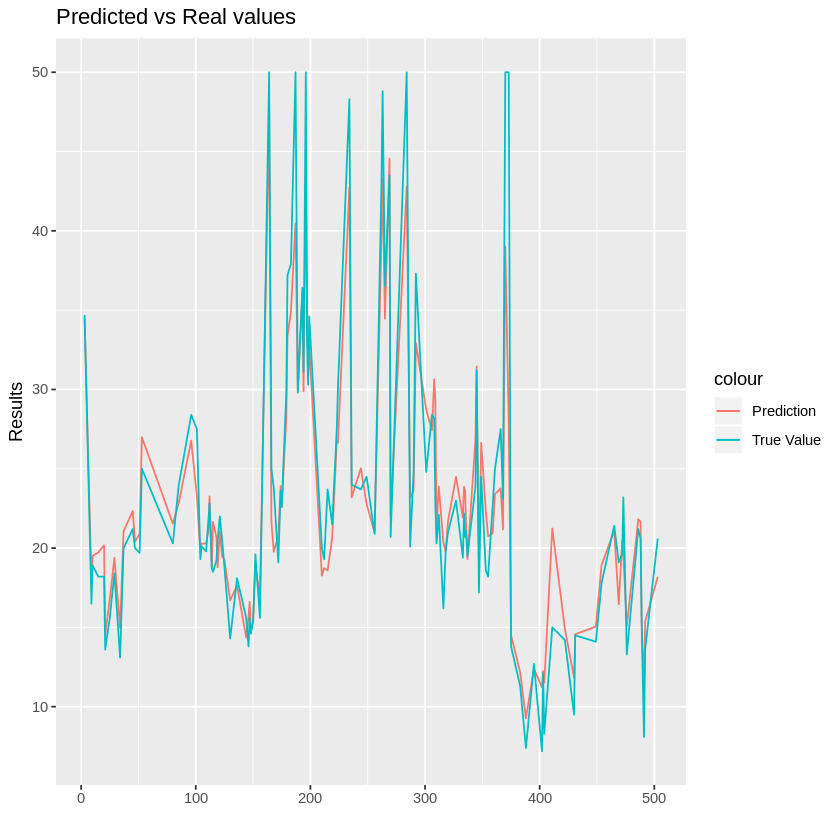

In [25]:
# Plot the predictions against real values
library(ggplot2)

plot_predictions = ggplot(prediction_output, aes(ID)) +
                    geom_line(aes(y = PREDICTION, colour = "Prediction")) +
                    geom_line(aes(y = REALVALUE, colour = "True Value")) +
                    xlab("") +
                    ylab("Results") +
                    ggtitle("Predicted vs Real values")
                    theme(legend.title=element_blank())

plot(plot_predictions)

Train and predict in Exasol
===========================

We will now make use of the UDF to train our model within the Exasol cluster. Inside the UDF we read the data from the database into a `data.frame` object which we use to run the model. We then send this model to BucketFS for future usage and return some model information (variable importance in this case).

In [27]:
TrainInExasol2 <- exa.createScript(
  exaconn,
  "r_demo.dt_train2",
  function(data) {

    # Load the required packages
    library(randomForest)
    library(RCurl)

    # Load the data into the UDF. 
    # CAUTION: UDF have only a limited ammount of main memory
    # Unfortunatly, most of the R packages for Machine Learning 
    # require the whole training set in memory.
    # We are going to show in other examples some libraries which
    # work with chunks of data
    if (!data$next_row(NA))
        break

    # Transform into data frame
    df <- data.frame(
          id       = data$id,
          crim     = data$crim,
          zn       = data$zn,
          indus    = data$indus,
          chas     = data$chas,
          nox      = data$nox,
          rm       = data$rm,
          age      = data$age,
          dis      = data$dis,
          rad      = data$rad,
          tax      = data$tax,
          ptratio  = data$ptratio,
          b        = data$b,
          lstat    = data$lstat,
          medv     = data$medv,
          split    = data$split
        )

    # Run random forest
    set.seed(42)
    rf_model2 <- randomForest(medv ~ .-id -split,
                              data = df[df$split=="Train",],
                              importance = TRUE)

    curl_opts = curlOptions(userpwd = sprintf("%s:%s",env$EXASOL_BUCKETFS_USER,env$EXASOL_BUCKETFS_PASSWORD),
                            verbose = TRUE,
                            httpauth=AUTH_BASIC)
    RCurl:::httpPUT(
      url     = sprintf("%s://%s/%s/%s",
                      env$EXASOL_BUCKETFS_PROTOCOL,env$EXASOL_BUCKETFS_HOST,
                      env$EXASOL_BUCKETFS_BUCKET,env$MODEL_NAME),
      content = serialize(rf_model2, ascii = FALSE, connection = NULL),
      curl    = getCurlHandle(.opts = curl_opts)
    )

    # Return the line number
    data$emit(rownames(rf_model2$importance),
              unname(rf_model2$importance[,1]),
              unname(rf_model2$importance[,2]))
  },
  env=UDF_ENV,
  # Input arguments
  inArgs  = c("id         INT",
              "crim       DOUBLE",
              "zn         DOUBLE",
              "indus      DOUBLE",
              "chas       VARCHAR(10)",
              "nox        DOUBLE",
              "rm         DOUBLE",
              "age        DOUBLE",
              "dis        DOUBLE",
              "rad        DOUBLE",
              "tax        DOUBLE",
              "ptratio    DOUBLE",
              "b          DOUBLE",
              "lstat      DOUBLE",
              "medv       DOUBLE",
              "split      VARCHAR(10)"),

  # Output arguments
  outArgs = c("Variable   CHAR(20)",
              "MSE        DOUBLE",
              "NodePurity DOUBLE")
)

tic("TrainInExasol2")
#Call of the function. The return is stored in an object
variable_importance = TrainInExasol2("id","crim", "zn", "indus", "chas", "nox", "rm", "age", "dis",
                                     "rad", "tax", "ptratio", "b", "lstat", "medv", "split",
                                     table = "r_demo.boston_housing",
                                     where = "split = 'Train'")
toc()

TrainInExasol2: 2.247 sec elapsed


Now that we have model, `rf_model2`, stored in BucketFS we will use it to make predictions on our test data which lives in the Exasol database. The testing procedure is the same as in the scenario above.

In [30]:
# TODO do we need the second definition? probably not
# TODO get bucketfd info from connection
# Create UDF for prediction
PredictInExasol2 <- exa.createScript(
  exaconn,
  "r_demo.dt_predict2",
  function(data) {

    # Load the required packages
    require(RCurl)
    require(randomForest)

    # Set options for retrieving model from bucket
    curl_opts = curlOptions(userpwd = sprintf("%s:%s",env$EXASOL_BUCKETFS_USER,env$EXASOL_BUCKETFS_PASSWORD),
                            verbose = TRUE,
                            httpauth=AUTH_BASIC)

    # Loading the model from the bucket (note that is unserialized)
    rf_model2 = unserialize(httpGET(url  = sprintf("%s://%s/%s/%s",
                                                  env$EXASOL_BUCKETFS_PROTOCOL,env$EXASOL_BUCKETFS_HOST,
                                                  env$EXASOL_BUCKETFS_BUCKET,env$MODEL_NAME),
                                   curl = getCurlHandle(.opts = curl_opts)))

    # Load data in chuks of 1000 rows at a time
    repeat{
        if (!data$next_row(1000))
            break

      # Load the data into a data.frame
      df <- data.frame(id       = data$id,
                       crim     = data$crim,
                       zn       = data$zn,
                       indus    = data$indus,
                       chas     = data$chas,
                       nox      = data$nox,
                       rm       = data$rm,
                       age      = data$age,
                       dis      = data$dis,
                       rad      = data$rad,
                       tax      = data$tax,
                       ptratio  = data$ptratio,
                       b        = data$b,
                       lstat    = data$lstat,
                       medv     = data$medv,
                       split    = data$split)


      # Use the loaded model to make the prediction
      prediction <- predict(rf_model2, newdata = df)
    }
      
    # Return the forecast
    data$emit(df$id, df$medv, prediction)
  },
  env=UDF_ENV,
  # iInput arguments
  inArgs  = c("id         INT",
              "crim       DOUBLE",
              "zn         DOUBLE",
              "indus      DOUBLE",
              "chas       VARCHAR(10)",
              "nox        DOUBLE",
              "rm         DOUBLE",
              "age        DOUBLE",
              "dis        DOUBLE",
              "rad        DOUBLE",
              "tax        DOUBLE",
              "ptratio    DOUBLE",
              "b          DOUBLE",
              "lstat      DOUBLE",
              "medv       DOUBLE",
              "split      VARCHAR(10)"),

  # Output arguments
  outArgs = c("id         INT",
              "RealValue  DOUBLE",
              "Prediction DOUBLE")
)

tic("PredictInExasol2")
# Create a table with the real values and predicted ones
prediction_output2 = PredictInExasol2("id","crim", "zn", "indus", "chas", "nox", "rm", "age", "dis",
                                      "rad", "tax", "ptratio", "b", "lstat", "medv", "split",
                                      table = "r_demo.boston_housing",
                                      groupBy = "iproc(),mod(rownum,5)",
                                      where = "split = 'Test'")
toc()

# Check the root mean squared error (RMSE)
RMSE = sqrt(mean((prediction_output2$PREDICTION - prediction_output2$REALVALUE)^2))
# 3.35, similar to the one above
print(RMSE)

PredictInExasol2: 1.747 sec elapsed
[1] 3.350155


Bonus: Predict via UDF in SQL
=============================

We can run the same exact prediction model from Exasol native environment in the SQL development tool. The model can be deployed using a UDF which dynamically executes R code. Much is the same as above, except for the way we get the data from the database via the context object `ctx`. See detailed information in [Exasol User Manual](https://www.exasol.com/support/secure/attachment/70209/EXASOL_User_Manual-6.1.0-en.pdf).

``` sql
-- 1. Create prediction function
CREATE OR REPLACE R SET SCRIPT r_demo.predict3(...) EMITS (id INT, RealValue DOUBLE, Prediction DOUBLE) AS

# Load library
library(randomForest)

# Get number of columns
numCols <- exa$meta$input_column_count

# Create empty list with length numCols
l = vector("list", numCols)

run <- function(ctx) {

  # Load the model from the bucket
  rf_model = readRDS("/buckets/bucketfs1/bucket1/rf_model")

  # ...or depending on the file type
  #load("/buckets/bucketfs1/bucket1/rf_model.dat")

  # Split input into modest sized chunks, this can be adjusted for memory consumption
  repeat{
    if (!ctx$next_row(1000000))
        break

  # Populate list with data columns
  for (i in 1:numCols){

        l[[i]] <- ctx[[i]]()

  }

  # Convert to data.frame for modelling
  df = as.data.frame(l)

  # Set the column names

  # From the model object, note: model/scenario specific
  # the_colnames <- names(rf_model$forest$xlevels)
  # colnames(df) = the_colnames

  # Assign manually, note: not dynamic
  # Note: case sensitive when using double quotes
  colnames(df) <- c("id", "crim", "zn", "indus", "chas", "nox", "rm",
  "age", "dis", "rad", "tax", "ptratio", "b", "lstat", "medv", "split")

  # Get predictions
  prediction   <- predict(rf_model, newdata = df)

  # Output ids, real values and predicted ones
  ctx$emit(df$id, df$medv, prediction)
  }
}
/

-- 2. Run prediction function
SELECT r_demo.predict3(id,crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, b, lstat, medv, split)
FROM   r_demo.boston_housing
WHERE  split = 'Test'
GROUP  BY IPROC()         -- Node number for data locality
        , MOD(ROWNUM, 5) -- Number of processes per node
ORDER  BY id;
```